In [1]:
def load_aws_credentials(profile_name):
    "Returns (access_key, secred_key) from ~/.aws/credentials for the given profile."
    import boto3
    ses = boto3.Session(profile_name=profile_name)
    creds = ses.get_credentials()
    return (creds.access_key, creds.secret_key)

In [2]:
import neuropythy as ny

ny.config['hcp_credentials'] = load_aws_credentials('hcp')

filename = '/home/jovyan/shared/HCP/115825/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
cii = ny.load(filename)
(lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
lh_bold.shape

(918, 59292)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

sid = 111312
sub = ny.hcp_subject(sid)
lh = sub.hemis['lh_LR59k']
rh = sub.hemis['rh_LR59k']
view_pos = np.array([0, 100.0, 0])
lh_mproj_front = ny.map_projection(chirality='lh', registration='fs_LR', center=view_pos, radius=np.pi/2)
lh_mproj_back = ny.map_projection(chirality='lh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
rh_mproj_front = ny.map_projection(chirality='rh', registration='fs_LR', center=view_pos, radius=np.pi/2)
rh_mproj_back = ny.map_projection(chirality='rh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
lh_fmap_front = ny.to_flatmap(lh_mproj_front, lh)
lh_fmap_back = ny.to_flatmap(lh_mproj_back, lh)
rh_fmap_front = ny.to_flatmap(rh_mproj_front, rh)
rh_fmap_back = ny.to_flatmap(rh_mproj_back, rh)

In [13]:
def sub_channel(lh_data, rh_data):
    (fig, axs) = plt.subplots(2, 2, figsize=(2,2), dpi=72*4)
    ny.cortex_plot(lh_fmap_front, axes=axs[0,0], color=lh_data[lh_fmap_front.labels], cmap='gray')
    ny.cortex_plot(lh_fmap_back, axes=axs[1,0], color=lh_data[lh_fmap_back.labels], cmap='gray')
    ny.cortex_plot(rh_fmap_front, axes=axs[0,1], color=rh_data[rh_fmap_front.labels], cmap='gray')
    ny.cortex_plot(rh_fmap_back, axes=axs[1,1], color=rh_data[rh_fmap_back.labels], cmap='gray')
    fig.subplots_adjust(0,0,1,1,0,0)
    for ax in axs.flatten():
        ax.axis('off')
    return fig

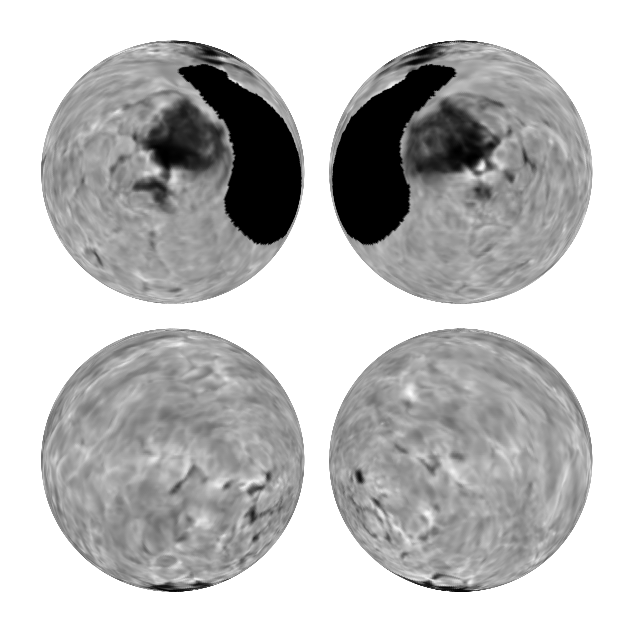

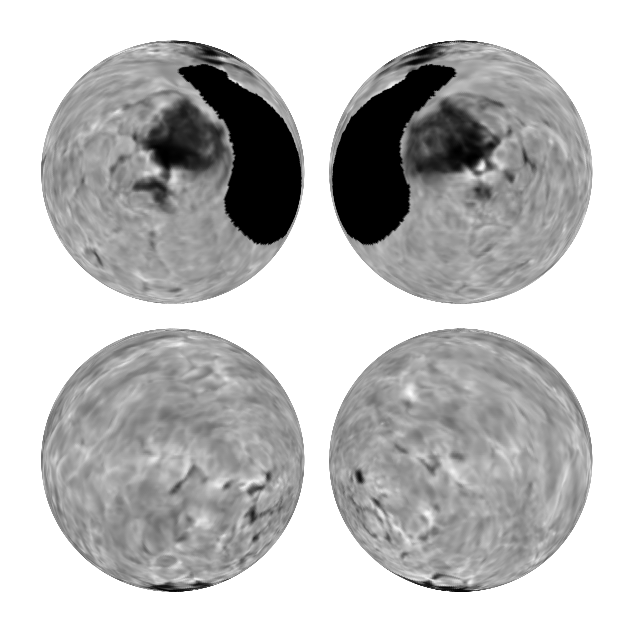

In [14]:
sub_channel(lh_bold[10], rh_bold[10])
plt.savefig('filename.png')